# Overfitting

We have barely scratched the surface of the big blob of available classification algorithms. There are many variations on kNN and decision trees, as well as algorithms we have not reached. And most learning algorithms have **hyperparameters** that control the complexity and theoretical resolving power of the algorithm. 

:::{note}
In ML, a *parameter* is a value that is adjusted during training; i.e., it is learned from the training data. A *hyperparameter* is one that is selected and remains fixed throughout the training. In most of mathematics, we would refer to these as *variables* and *parameters*, and sources aren't always fastidious about the latter term.
:::

An obvious question about hyperparameters is: Why not just use maximum algorithm power all the time? It's not simply a matter of computing resource limitations, although those can be significant. More importantly, too much resolving power causes a classifier to learn not just major trends, but idiosyncratic details about the training set that may not generalize well, a phenomenon known as **overfitting**.

## Overfitting in kNN

Consider a kNN classifier with $k=1$. The class assigned to each value is just that of the nearest training example, making for a piecewise constant labelling. Let's see how this plays out in about as simple a classification problem as we can come up with: a single feature, with the class being the sign of the feature's value. (We can also assign zero to have class 1.) Using $k=1$ produces fine results, as shown here for 4 different training sets of size 40:

```{image} ../_static/knn_step_k1.png
:alt: kNN with k=1, perfect data
:width: 320px
:align: center
```

Now suppose we use training sets that have just 3 mislabeled examples. Here are some resulting classification functions:

```{image} ../_static/knn_noisy_k1.png
:alt: kNN with k=1, noisy data
:width: 320px
:align: center
```

Each individual result is good over much of the domain, but wrong over some parts. Each one is wrong over a relatively small part of the domain, but the details depend on the particulars of the training set. On different days you will get a lot of different answers. 

Now let's bump up to $k=3$. The results are much more consistent:

```{image} ../_static/knn_noisy_k3.png
:alt: kNN with k=3, noisy data
:width: 320px
:align: center
```

The voting mechanism of kNN allows the classifier to ignore isolated outliers. If we continue to $k=7$, then the 3 outliers will never be able to outvote the correct values. The decision boundary between negative and positive also depends less on exactly where the points happen to lie:

```{image} ../_static/knn_noisy_k7.png
:alt: kNN with k=7, noisy data
:width: 320px
:align: center
```

The choice $k=1$ is an extreme case of overfitting. In any number of dimensions, each training sample's nearest neighbor is itself, so the classifier will always perfectly fit the training data–including any incorrect or atypical values. 

However, the lesson is *not* simply that "bigger $k$ is better." Consider that in the extreme case of $k=21$, the classifier will predict the same result everywhere! If the true classification boundary were more complicated (i.e., if the classes switched back and forth at high frequency), using even $k=7$ would be unable to capture many of the details. What increasing $k$ does provide is much greater stability, both in the sense of slow variation over feature space, and in weaker dependence on the training set. If we think that a complicated decision boundary is unlikely, then both of these properties are desirable to some extent.

We can see this phenomenon play out with real data, too. Let's apply kNN to the loan application data, using many different subsets of the training data in order to simulate what happens in parallel universes. We will use (1 $-$ accuracy) as a measurement of error.

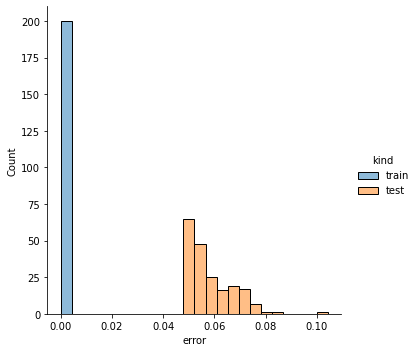

In [1]:
from sklearn import neighbors,metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import seaborn as sns

loans = pd.read_csv("loan_clean.csv")
X = loans.drop("percent_funded",axis=1)
y = loans["percent_funded"] > 95
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2)

n = 1000             # size of the training subset
err,kind = [],[]     # track information for the results
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
for i in range(200):
    X_tr,y_tr = shuffle(X_tr,y_tr,random_state=1)
    XX,yy = X_tr.loc[:n,:],y_tr.loc[:n]
    knn.fit(XX,yy) 
    err.append(1-knn.score(XX,yy))       # training error
    err.append(1-knn.score(X_te,y_te))   # test error
    kind.extend(["train","test"])

result = pd.DataFrame({"error":err,"kind":kind})
sns.displot(data=result,x="error",hue="kind",bins=24);

As anticipated, the training error (blue histogram) is always zero. But the testing error (orange histogram) tells a very different story. The hallmarks of overfitting are a large gap between training and test performance---i.e., poor generalization---and large variance in the testing error due to the sensitive dependence.

As with the toy example, increasing $k$ in the kNN classifier reduces the tendency to overfit.

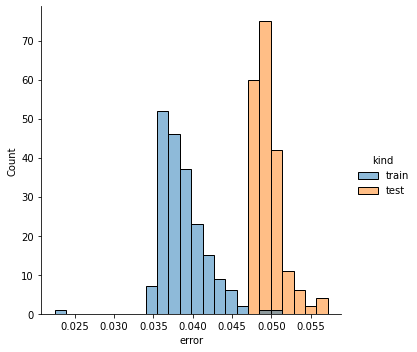

In [2]:
err,kind = [],[]     # track information for the results
knn = neighbors.KNeighborsClassifier(n_neighbors=6)
for i in range(200):
    X_tr,y_tr = shuffle(X_tr,y_tr,random_state=1)
    XX,yy = X_tr.loc[:n,:],y_tr.loc[:n]
    knn.fit(XX,yy) 
    err.append(1-knn.score(XX,yy))       # training error
    err.append(1-knn.score(X_te,y_te))   # test error
    kind.extend(["train","test"])

result = pd.DataFrame({"error":err,"kind":kind})
sns.displot(data=result,x="error",hue="kind",bins=24);

Note above how the training error is more comparable to the testing error, and the variance in the testing error is much smaller than before. (The horizontal axis scaling is different in the two plots.)

## Bias–variance tradeoff

Suppose that $f(x)$ is a function giving the ground truth over the entire population. Let $\hat{f}(x)$ denote a classification function obtained after training. Conceptually, $\hat{f}$ is just one realization that we get from one particular training set. We use $E[\cdot]$ to denote the process of averaging over all possible training sets. Note that the mean of a sum of quantities is the sum of the means.

The mean error is

$$
E\bigl[ f(x) - \hat{f}(x) \bigr] = f(x) - E\bigl[ \hat{f}(x) \bigr] = y - \hat{y},
$$

where $y=f(x)$ and $\hat{y}$ is the mean prediction over all training sets. This quantity is called the **bias**. Next, we look at mean squared error:

$$
E\bigl[ (f(x) - \hat{f}(x))^2 \bigr] &= E\bigl[ (f(x) - \hat{y} + \hat{y} - \hat{f}(x))^2 \bigr] \\ 
&= E\bigl[ (f(x) - \hat{y})^2 \bigr] + E\bigl[ (\hat{y} - \hat{f}(x))^2 \bigr] - 2E\bigl[ (f(x) - \hat{y})(\hat{y} - \hat{f}(x)) \bigr] \\ 
&= (f(x) - \hat{y})^2 + E\bigl[ (\hat{y} - \hat{f}(x))^2 \bigr] - 2(f(x) - \hat{y}) E\bigl[ \hat{y} - \hat{f}(x) \bigr] \\
&= (f(x) - \hat{y})^2 + E\bigl[ (\hat{y} - \hat{f}(x))^2 \bigr].
$$

The first term is the squared bias. The second is the **variance** of the learning method. In words,

* **Bias** How close is the average prediction to the ground truth? 
* **Variance** How close to the average prediction is any one prediction likely to be?

There is a crude analogy with hitting the bullseye on a dartboard. A low-variance, high-bias learner will throw a tight cluster of darts far from the bullseye. A low-bias, high-variance learner will scatter the darts evenly all over the board. When learners are overfitted, their output on a test set depends sensitively on the choice of training set, which creates a large variance.

When a hyperparameter adjusts the number of degrees of freedom available to use for fitting, there might be decreased bias, simply because there is a larger universe of potential classifiers to choose from. But if taken too far, this approach tends to increase variance, because the higher fidelity is actually used to fit more closely to the particular training set that is chosen. This dilemma is generally known as the **bias–variance tradeoff**. This observation leads to an application of **Occam's Razor**: given methods with equal empirical error, choose the least complex one.

## Learning curves

We can illustrate the presence of bias and variance by running an artificial experiment with different sizes for the training datasets. In order to have more data to pull from, we will use a subset of a realistic data set used to predict the dominant type of tree in patches of forest. We use a decision tree classifier with fixed depth throughout. (Don't confuse the forest data for the tree classifier, haha.)

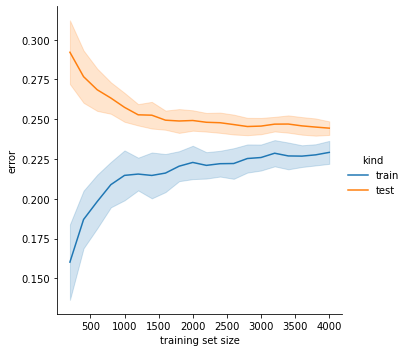

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets

forest = datasets.fetch_covtype()
X = forest["data"][:250000,:8]   # 250,000 samples, 8 feature dimensions
y = forest["target"][:250000]
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.05,shuffle=True,random_state=0)

N = range(200,4001,200)             # sizes of the training subsets
err,kind,length = [],[],[]          # for storing results
dt = DecisionTreeClassifier(max_depth=4) 
for n in N:
    for i in range(50):
        X_tr,y_tr = shuffle(X_tr,y_tr,random_state=1)
        XX,yy = X_tr[:n,:],y_tr[:n]         # training subset of size n
        dt.fit(XX,yy)
        err.append(1-dt.score(XX,yy))       # training error
        err.append(1-dt.score(X_te,y_te))   # testing error
        kind.extend(["train","test"])
        length.extend([n,n])

result = pd.DataFrame({"error":err,"kind":kind,"training set size":length})
sns.relplot(data=result,x="training set size",y="error",kind="line",ci="sd",hue="kind");

The plot above shows **learning curves**. The solid line is the mean result over all trials, and the ribbon has a width of one standard deviation. For a small training set, the tree has more than enough resolving power, and we see indications of overfitting. As the size of the training set grows, however, the two error measurements come together as the variance decreases. Note that the curves seem to approach a horizontal asymptote at a nonzero level of error. This level indicates an unavoidable bias for this learner on this data set. As a simple analogy, think about approximating curves in the plane by a parabola. You will be able to do a perfect job for linear and quadratic functions, but if you approximate a cosine curve, you can't get it exactly correct no matter how much information and control you have. 

When you see a large gap between training and test errors, you should suspect that you are in an overfitting regime. Ideally, you could bring more data to the table, perhaps by artificially augmenting the training examples. If not, you might as well decrease the resolving power of your learner, because the excess power is likely to make things worse, not better.


<div style="max-width:608px"><div style="position:relative;padding-bottom:66.118421052632%"><iframe id="kaltura_player" src="https://cdnapisec.kaltura.com/p/2358381/sp/235838100/embedIframeJs/uiconf_id/43030021/partner_id/2358381?iframeembed=true&playerId=kaltura_player&entry_id=1_j2tazorb&flashvars[streamerType]=auto&amp;flashvars[localizationCode]=en&amp;flashvars[leadWithHTML5]=true&amp;flashvars[sideBarContainer.plugin]=true&amp;flashvars[sideBarContainer.position]=left&amp;flashvars[sideBarContainer.clickToClose]=true&amp;flashvars[chapters.plugin]=true&amp;flashvars[chapters.layout]=vertical&amp;flashvars[chapters.thumbnailRotator]=false&amp;flashvars[streamSelector.plugin]=true&amp;flashvars[EmbedPlayer.SpinnerTarget]=videoHolder&amp;flashvars[dualScreen.plugin]=true&amp;flashvars[Kaltura.addCrossoriginToIframe]=true&amp;&wid=1_b8hiad73" width="608" height="402" allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" frameborder="0" title="Kaltura Player" style="position:absolute;top:0;left:0;width:100%;height:100%"></iframe></div></div>